# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
import scipy
from scipy.optimize import curve_fit
import statsmodels.api as sm

colors = sns.color_palette("hls", 8)   # Colors
title_size = 16                        # Size title
axis_size = 14                         # Size axis label
value_size = 10                        # Size values on axis
legend_size = 12                       # Size legend

## Exercise 07.1
### Assignment
In the NSL simulator code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

### Solution

Tail corrections allow for the correction of the missing long-range part of the potential and pressure that is neglected by the spherical cut-off at the cut-off distance $r_c$. For the Lennard-Jones potential, the tail corrections for potential and pressure are:

$$\frac{\left< V_{LJ} \right>_{tail}}{N\epsilon} = \frac{8 \pi \rho^*}{3{r^*_c}^3} \left( \frac{1}{3{r^*_c}^6} - 1\right)$$
$$\frac{\left< w_{LJ} \right>_{tail}}{3N\epsilon} = \frac{32 \pi \rho^*}{3{r^*_c}^3} \left( \frac{1}{3{r^*_c}^6} - \frac{1}{2}\right)$$

where $\rho^*$ and $r^*_c$ in reduce units.

These corrections were implemented in `void System ::initialize_properties()`:

```cpp
// ... //
if (property == "POTENTIAL_ENERGY") 
{
    // ... // 
    _vtail = (8. * M_PI * _rho) / (3. * pow(_r_cut, 3)) * ( 1. / (3. * pow(_r_cut, 6)) - 1.); 
}
// ... //
else if (property == "PRESSURE") 
{
    // ... //
    _ptail = (32. * M_PI * _rho) / (3. * pow(_r_cut, 3)) * ( 1. / (3. * pow(_r_cut, 6)) - 0.5); 
} 
```

The contribution of tail corrections was added to the measured values.

## Exercise 07.2
### Assignment

Use the NSL simulator code to print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. Make pictures of these statistical uncertainties as a function of $L$. What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

### Solution

To achieve a Metropolis algorithm acceptance of approximately 50%, I created the `double Accep_50()` function, which tries different values of $\delta$ using the bisection method until it reaches an acceptance of 50% within a fixed uncertainty. For the bisection method I set the starting left value of $\delta = 0.005$ and the starting right value equal to the side of the box.

With this function:

- For the solid system I reached an acceptation of 49.9% with $\delta =0.056$
- For the liquid system I reached an acceptation of 50.1% with $\delta = 0.103$
- For the gas system I reached an acceptation of 61.3% with $\delta = 11.311$ 

While I achieved an acceptance rate of 50% for the solid and liquid systems, the acceptance rate for the gas remains around 60% at different values of $\delta$, likely due to the infrequent interactions between particles.

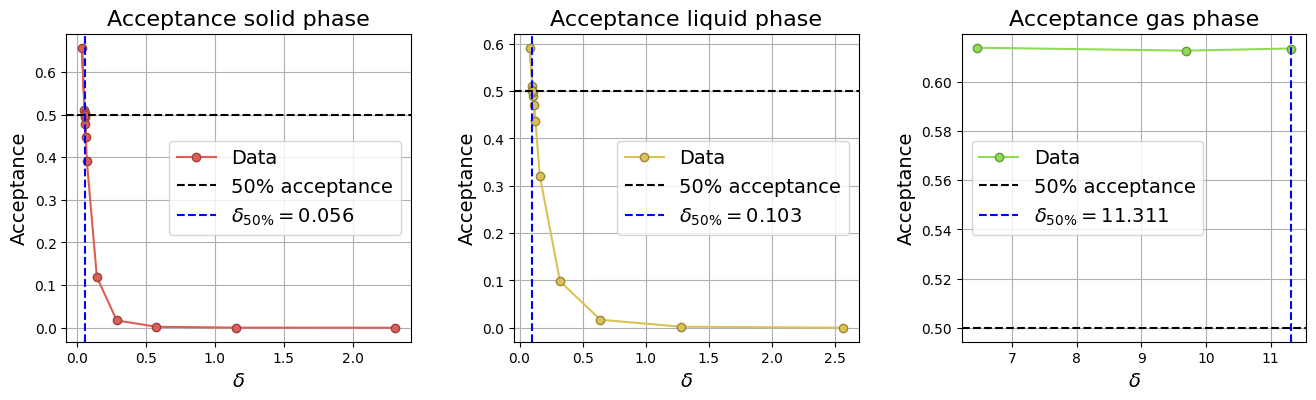

In [4]:
# Plot acceptance
plt.figure(figsize=(16, 4))
path = ["../E07/e07_2/SOLID/OUTPUT/accep_delta.dat", "../E07/e07_2/LIQUID/OUTPUT/accep_delta.dat", "../E07/e07_2/GAS/OUTPUT/accep_delta.dat"] # Path to data
title = ["solid", "liquid", "gas"] # Title of the plot

for i in range(len(path)):      # Loop over the phases
    df = pd.read_csv(path[i], sep=' ') # Read data
    plt.subplot(1, len(path), i + 1)
    plt.plot(df["delta"], df["accep"], color = colors[i], linewidth=1.5, marker='o', mec=tuple(np.array(colors[i]) * 0.7), label="Data")
    plt.axhline(y=0.5, color='black', linestyle='--', label=r"50% acceptance")
    plt.axvline(x=df["delta"][len(df) - 1], color='blue', linestyle='--', label=r"$\delta_{50\%} = $" + str(round(df["delta"][len(df) - 1], 3)))
    plt.title("Acceptance " + title[i] + " phase", fontsize=title_size)
    plt.xlabel(r'$\delta$', fontsize=axis_size)
    plt.ylabel('Acceptance', fontsize=axis_size)
    plt.legend(fontsize=axis_size)
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.grid(True)

plt.subplots_adjust(wspace = 0.3)
plt.show()

Using the `void System ::print_penergy()` method, I calculated and printed the instantaneous potential energy of the systems for $M = 10^5$ steps.

As expected, the energy of the solid system is the lowest, followed by the liquid system, with the gas system having the highest energy.

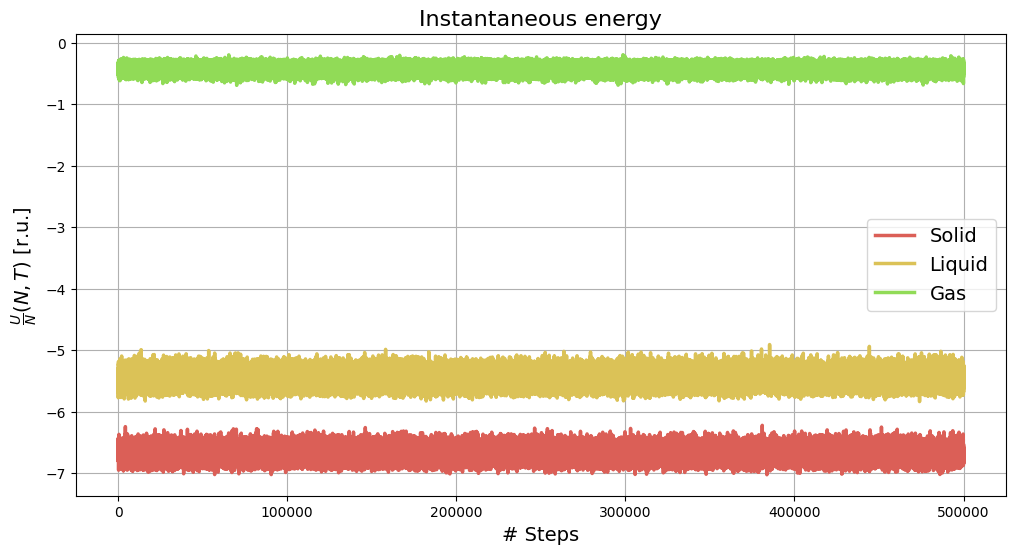

In [5]:
# Plot instantaneous energy
plt.figure(figsize=(12, 6))
path = ["../E07/e07_2/SOLID/OUTPUT/U_step.dat", "../E07/e07_2/LIQUID/OUTPUT/U_step.dat", "../E07/e07_2/GAS/OUTPUT/U_step.dat"] # Path to data
label = ["Solid", "Liquid", "Gas"] # Label of the plot

for i in range(len(path)):     # Loop over the phases
    df = pd.read_csv(path[i], sep=' ') # Read data
    plt.plot(df["STEP"], df["U"], color = colors[i], linewidth=2.5, label=label[i])
    plt.title("Instantaneous energy", fontsize=title_size)
    plt.xlabel('# Steps', fontsize=axis_size)
    plt.ylabel(r'$\frac{U}{N}(N, T)$ [r.u.]', fontsize=axis_size)
    plt.legend(fontsize=axis_size)
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.grid(True)

plt.show()

Autocorrelation at lag $t$ is defined as:

$$\chi(t) = \frac{\langle x(t_0)x(t_0+t)\rangle - \langle x(t_0)\rangle^2}{\langle x(t_0)^2\rangle - \langle x(t_0)\rangle^2}$$

The autocorrelation of the energies decays exponentially to zero, proportional to $e^{-\frac{t}{\tau_c}}$ where $\tau_c$ is the correlation time, which gives an estimate for how long the process maintains a memory of itself and how many step should be in a block. 

I performed an exponential fit on the autocorrelations, calculated using `sm.tsa.acf` function, to obtain the correlation time and the block size (number of independent measurements $\sim 2\tau_c$):
- Solid phase $\tau_c = 9.44$ and $N_{steps} \sim 19$.
- Liquid phase $\tau_c = 11.23$ and $N_{steps} \sim 22$.
- Gas phase $\tau_c = 2.16$ and $N_{steps} \sim 4$.

The solid and liquid phases have similar autocorrelation and correlation times. While gas phase has the smallest correlation time due to that it is much more disordered and the greater distance among particles leads weaker potential interaction and hence a short time correlation.

Solid phase
Number of block:  26469.757199503358
Independent measurements:  18.889481918231624
Liquid phase
Number of block:  22271.643720804273
Independent measurements:  22.450071771440136
Gas phase
Number of block:  115490.06242446687
Independent measurements:  4.329376826919731


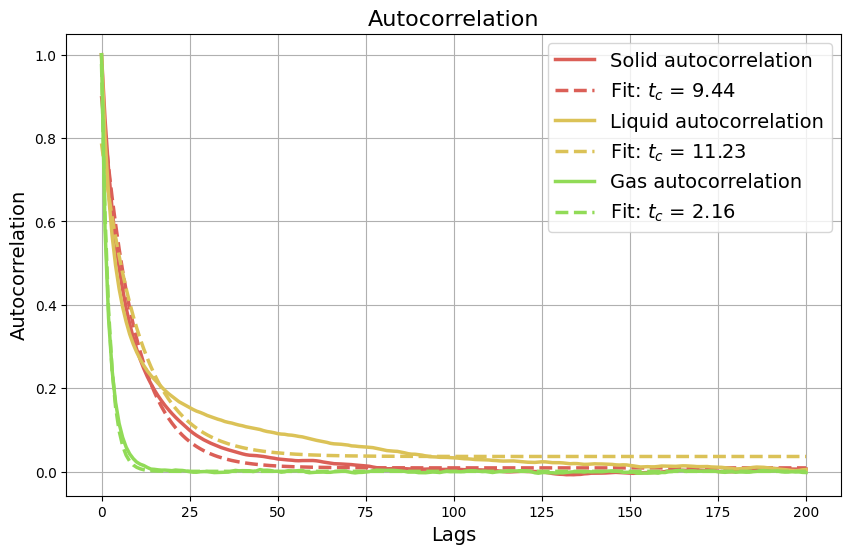

In [2]:
# Exp function
def f(x, t_c, A, B):
    return A * np.exp(-x / t_c) + B

plt.figure(figsize=(10, 6))
path = ["../E07/e07_2/SOLID/OUTPUT/U_step.dat", "../E07/e07_2/LIQUID/OUTPUT/U_step.dat", "../E07/e07_2/GAS/OUTPUT/U_step.dat"] # Path to data
label = ["Solid", "Liquid", "Gas"] # Label of the plot
max_lag = 200 # Max lag

for i in range(len(path)):    # Loop over the phases
    df = pd.read_csv(path[i], sep=' ') # Read data
    auto_corr = sm.tsa.acf(df["U"], nlags = max_lag) # Autocorrelation
    plt.plot(range(len(auto_corr)), auto_corr, color = colors[i], linewidth=2.5, label=label[i] + " autocorrelation")
        
    # Fit
    popt, pcov = curve_fit(f, np.arange(len(auto_corr)), auto_corr)
    t_c_opt, A_opt, B_opt = popt  # Parameters
    plt.plot(np.arange(len(auto_corr)), f(np.arange(len(auto_corr)), t_c_opt, A_opt, B_opt), linestyle='--', color = colors[i], linewidth=2.5, label=fr'Fit: $t_c$ = {t_c_opt:.2f}')
    
    plt.title("Autocorrelation", fontsize=title_size)
    plt.xlabel('Lags', fontsize=axis_size)
    plt.ylabel('Autocorrelation', fontsize=axis_size)
    plt.legend(fontsize=axis_size)
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.grid(True)

    print(label[i] + " phase")
    print("Number of block: ",  len(df['U']) / 2 / t_c_opt)  # Steps each block
    print("Independent measurements: ",  2 * t_c_opt)  # Blocks number

plt.show()

Choosing the correct block size prevents underestimating the statistical uncertainty caused by data correlation. To find the block size where there is no longer any correlation between the data, I plotted the progressive uncertainty obtained using data blocking on the energy data as a function of the block size $L$.

As seen in the plot, the uncertainty saturates as the number of steps increases. A block size of $N_{steps}= 1000$ is a reasonable solution to avoid underestimating the uncertainty. Using a larger number would not provide a significant statistical advantage but would only increase the computational cost.

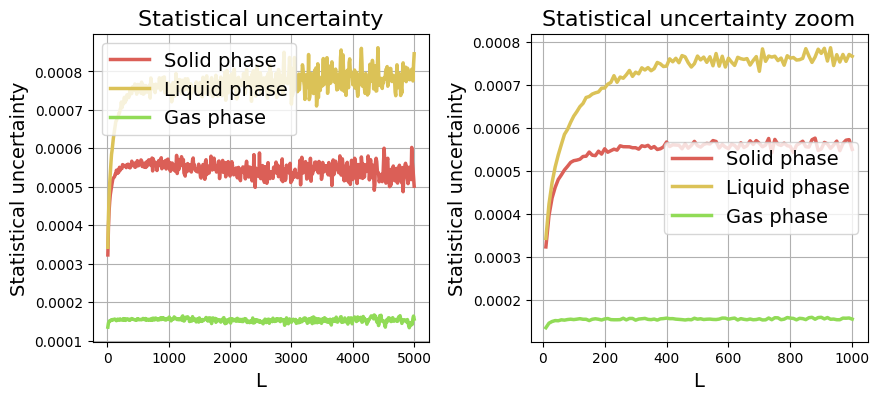

In [2]:
def error(AV, AV2, n):  
    if n == 0:
        return 0
    else:
        return math.sqrt((AV2 - AV**2) / n)

plt.figure(figsize=(10, 4))
path = ["../E07/e07_2/SOLID/OUTPUT/U_step.dat", "../E07/e07_2/LIQUID/OUTPUT/U_step.dat", "../E07/e07_2/GAS/OUTPUT/U_step.dat"] # Path to data
label = ["Solid", "Liquid", "Gas"] # Label of the plot
L_min = 10   # Min block size
L_max = 5000 # Max block size
step = 10    # Step block size
L_array = np.arange(L_min, L_max + 1, step) # Block size array
uncer_s = np.zeros(len(L_array))            # Uncertainty array

for i in range(len(path)):              # Loop over the phases
    df = pd.read_csv(path[i], sep=' ')  # Read data
    for L in L_array:                   # Loop over the block size
        block_number = int(len(df['U']) / L)  
        mean = np.zeros(block_number)
        mean2 = np.zeros(block_number)
        for j in range(block_number):
            mean[j] = np.mean(df['U'][j * L : (j + 1) * L])
            mean2[j] = mean[j]**2
        mean_prog = np.mean(mean)
        mean2_prog = np.mean(mean2)
        uncer_s[int((L - L_min) / step)] = error(mean_prog, mean2_prog, block_number - 1)
    plt.subplot(1, 2, 1)
    plt.plot(L_array, uncer_s, color = colors[i], linewidth=2.5, label=label[i] + " phase")
    plt.title("Statistical uncertainty", fontsize=title_size)
    plt.xlabel('L', fontsize=axis_size)
    plt.ylabel('Statistical uncertainty', fontsize=axis_size)
    plt.legend(fontsize=axis_size)
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(L_array[:100], uncer_s[:100], color = colors[i], linewidth=2.5, label=label[i] + " phase")
    plt.title("Statistical uncertainty zoom", fontsize=title_size)
    plt.xlabel('L', fontsize=axis_size)
    plt.ylabel('Statistical uncertainty', fontsize=axis_size)
    plt.legend(fontsize=axis_size)
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.grid(True)

plt.subplots_adjust(wspace = 0.3)
plt.show()

## Exercise 07.3
### Assignment

Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

### Solution

The radial distribution function $g(r)$ is calculated by the following formula:

$$g(r) =\frac{1}{\rho N\Delta V(r)}\left< \sum_{i=1}^N \sum_{i \neq j=1}^N \delta(r-|\vec r_i-\vec r_j |) \right>$$
where $\Delta V(r) = \frac{4\pi}{3}\left[(r+dr)^3-r^3\right]$

I implemented it in `void System ::measure()`, increasing the counter of the bin corresponding to the considered distance by two:

```cpp
if (_measure_penergy or _measure_pressure or _measure_gofr)
{
	for (int i = 0; i < _npart - 1; i++) 
	{
    	for (int j = i + 1; j < _npart; j++) 
		{
			// ... // 
			if (_measure_gofr && dr <= _halfside.min())
			{
				int index = floor(dr / _bin_size); // Find the index corresponding to the distance
				double norm = 3. / (_rho * _npart * 4. * M_PI * (pow((index + 1) * _bin_size, 3) - pow((index) * _bin_size, 3))) ;	// Normalization
				_measurement(_index_gofr + index) += 2. * norm;  // Increase the value of the bin with normalization
			}
		}
	}
}
```

## Exercise 07.4
### Assignment

By means of your upgraded NSL simulator code, equilibrate and perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.

### Solution

I conducted MC NVT simulations using values of $\delta$ obtained in Exercise 07.2. From the same exercise, observing that the uncertainty saturats after a few steps, I chose $N_{steps} = 1000$. I used $N_{block} = 50$ after the equilibration.

For the MD NVE simulations, I used the results (starting temperature, configuration and velocities) obtained in Exercise 04, using $N_{block} = 50$ after the equilibration and $N_{steps} = 1000$.

The results of the simulations are very similar, as can be seen from the plot of the difference in the radial distribution function.
All three radial distribution functions do not have particles in the region where the potential diverges; instead, they exhibit a peak corresponding to the energy minimum. The solid and liquid phases show additional smaller peaks, likely due to their more ordered structure compared to the gas phase.

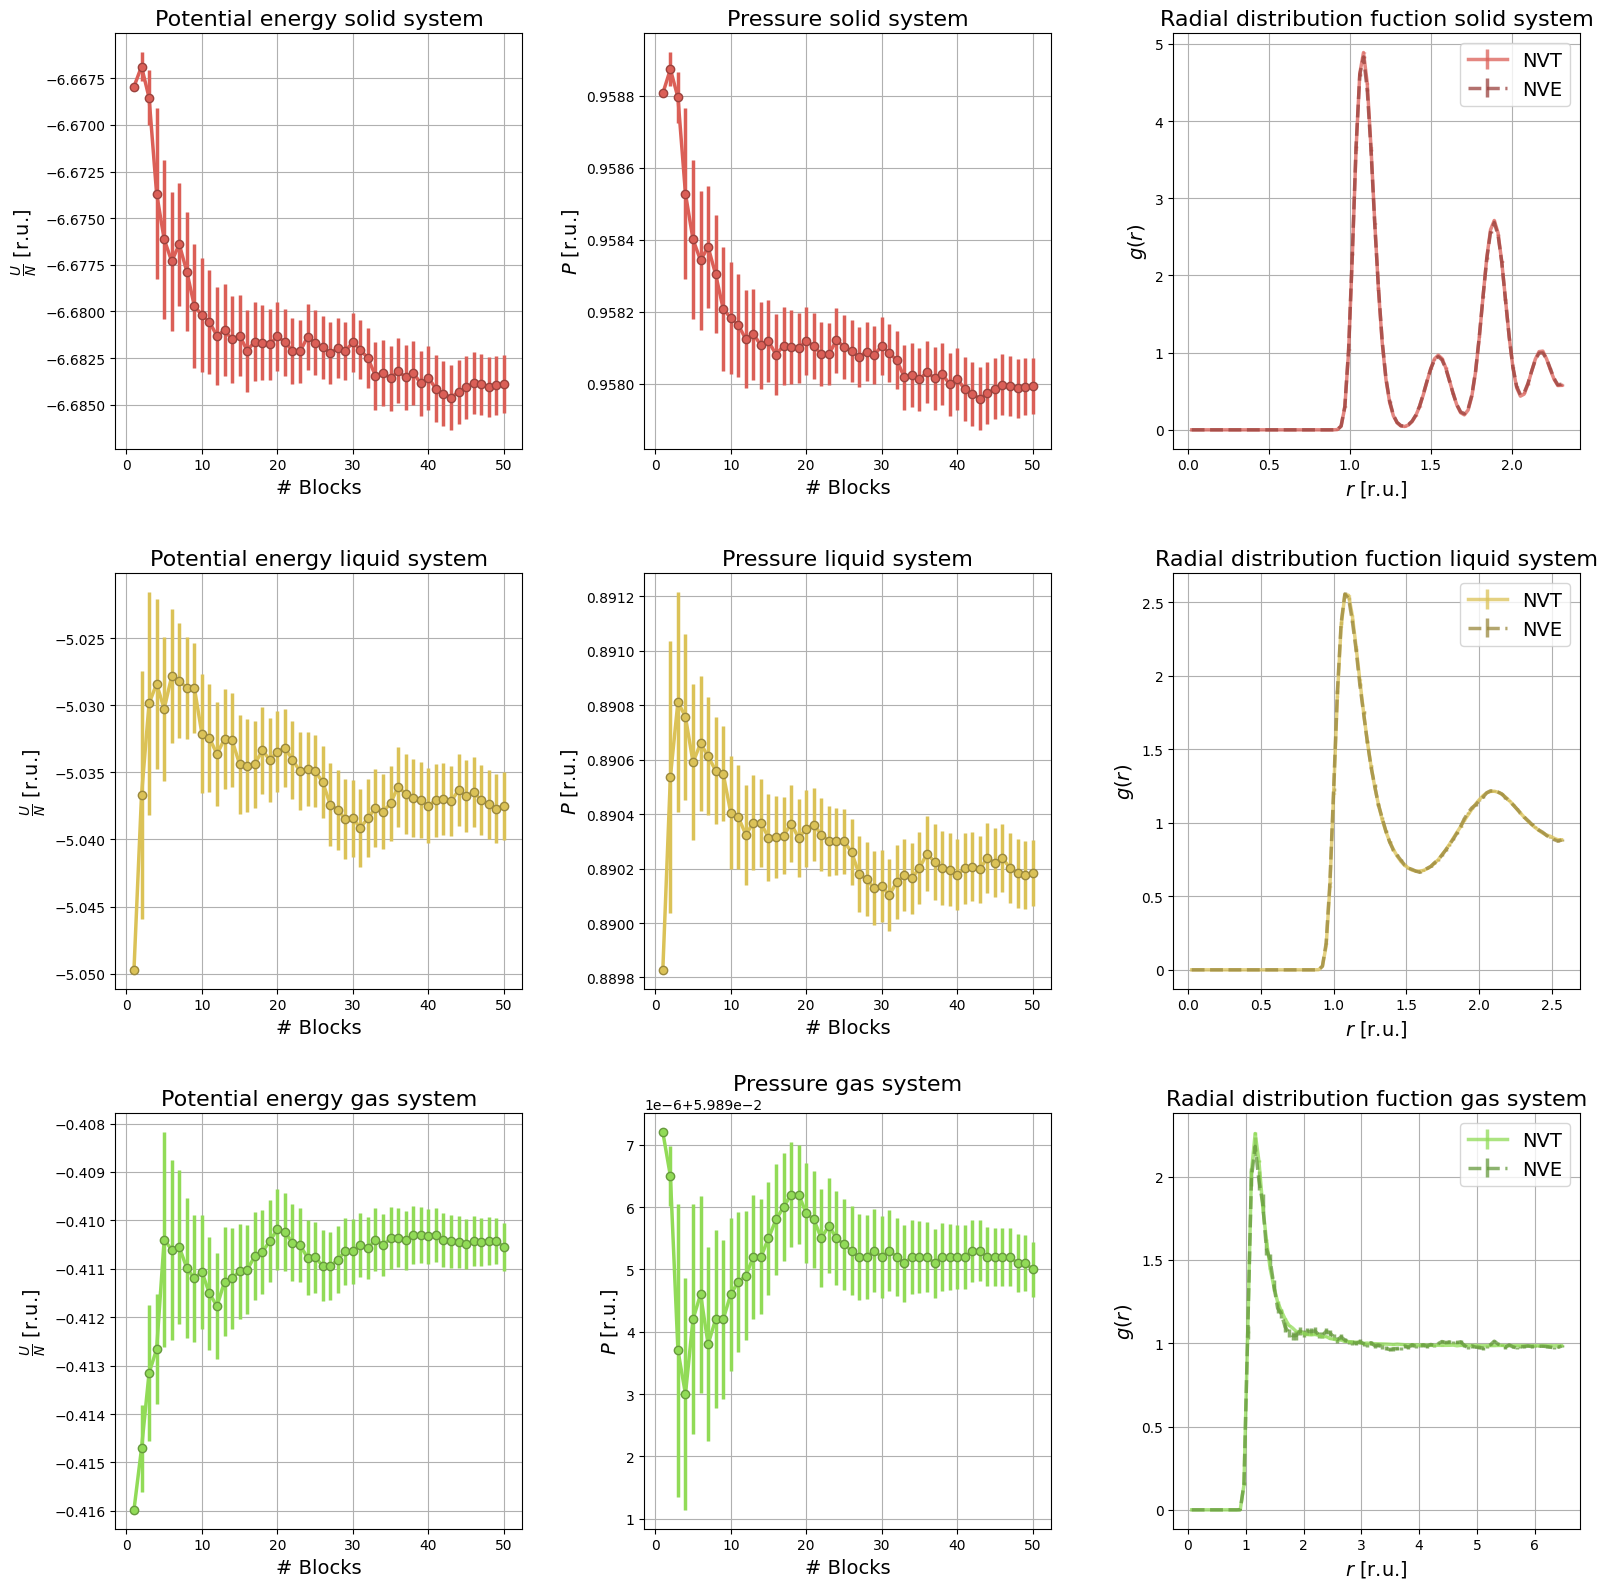

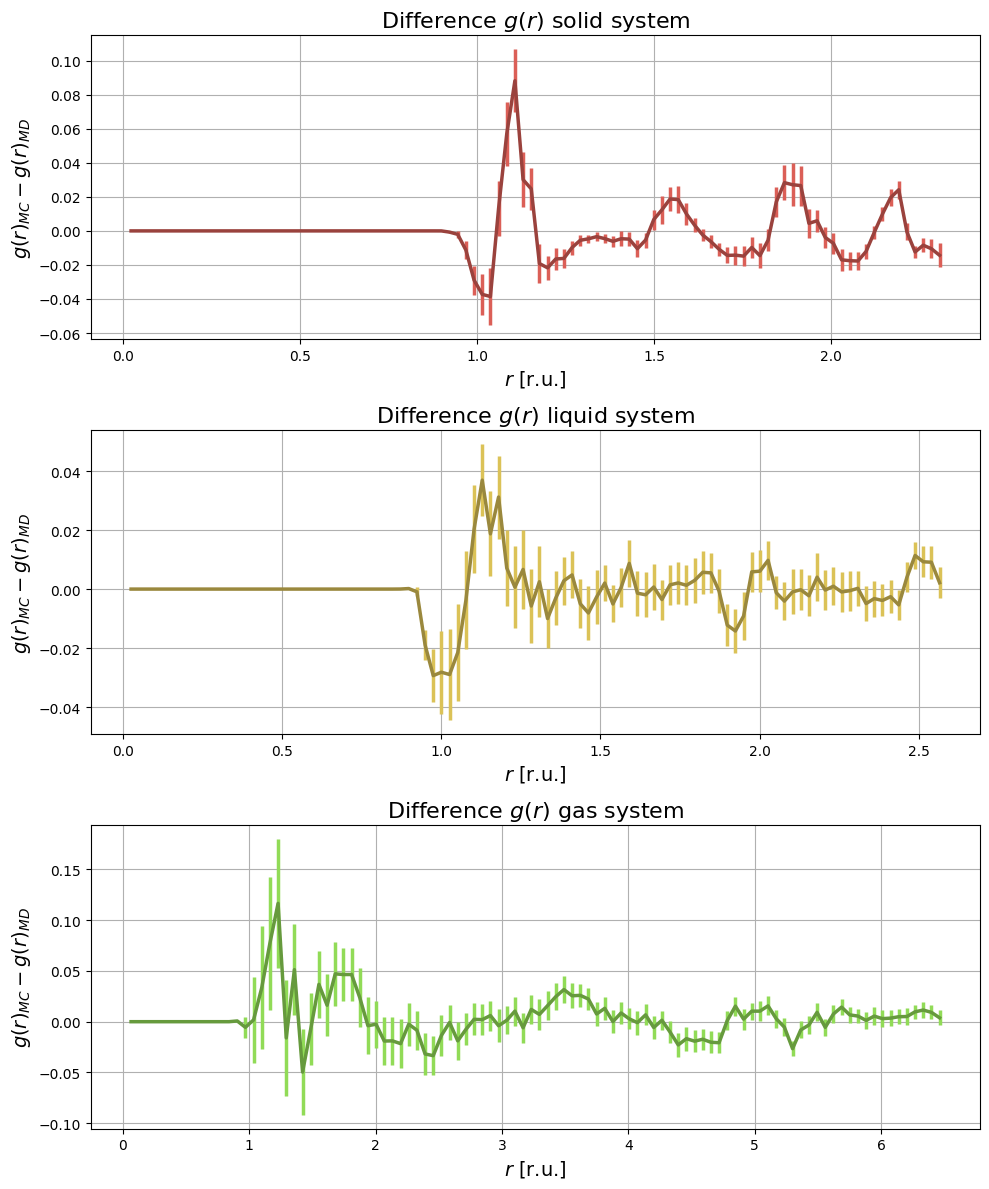

In [131]:
path = ["../E07/e07_4/SOLID/", "../E07/e07_4/LIQUID/", "../E07/e07_4/GAS/"] # Path to data
simul = ["NVT/OUTPUT/", "NVE/OUTPUT/"] # Simulation type
phase = ["solid", "liquid", "gas"] # Phase

plt.figure(figsize=(16, 16))

for i in range(len(path)):     # Loop over systems

# Potential energy
    df = pd.read_csv(path[i] + simul[0] + 'potential_energy.dat', delimiter=' ')  # Import data
    
    # Plot potential energy
    plt.subplot(3, 3, 3 * i + 1)
    plt.errorbar(df['#BLOCK'], df['AVE'], yerr = df['ERROR'], color = colors[i], marker='o', mec=tuple(np.array(colors[i]) * 0.7), linewidth=2.5)
    plt.title("Potential energy " + phase[i] + " system", fontsize=title_size)
    plt.xlabel(r'# Blocks', fontsize=axis_size)
    plt.ylabel(r'$\frac{U}{N}$ [r.u.]', fontsize=axis_size)
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.grid(True) 

# Pressure
    df = pd.read_csv(path[i] + simul[0] + 'pressure.dat', delimiter=' ')  # Import data
   
    # Plot pressure
    plt.subplot(3, 3, 3 * i + 2)
    plt.errorbar(df['#BLOCK'], df['AVE'], yerr = df['ERROR'], color = colors[i], marker='o', mec=tuple(np.array(colors[i]) * 0.7), linewidth=2.5)
    plt.title("Pressure " + phase[i] + " system", fontsize=title_size)
    plt.xlabel(r'# Blocks', fontsize=axis_size)
    plt.ylabel(r'$P$ [r.u.]', fontsize=axis_size)
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.grid(True) 

# Radial distribution fuction
    df = pd.read_csv(path[i] + simul[0] + 'gofr.dat', delimiter=' ', index_col=False)  # Import data MC NVT simulations
    df_2 = pd.read_csv(path[i] + simul[1] + 'gofr.dat', delimiter=' ', index_col=False)  # Import data MD NVE simulations

    # Plot g(r)
    plt.subplot(3, 3, 3 * i + 3)
    plt.errorbar(df['DISTANCE'], df['AVE'], yerr = df['ERROR'], color = colors[i], linewidth=2.5, alpha= 0.75, label="NVT")
    plt.errorbar(df_2['DISTANCE'], df_2['AVE'], yerr = df_2['ERROR'], linestyle='--', color = np.array(colors[i]) * 0.7, linewidth=2.5,  alpha= 0.75, label="NVE")
    plt.title("Radial distribution fuction " + phase[i] + " system", fontsize=title_size)
    plt.xlabel(r'$r$ [r.u.]', fontsize=axis_size)
    plt.ylabel(r'$g\left( r \right)$', fontsize=axis_size)
    plt.legend(fontsize=axis_size)
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.grid(True) 

plt.tight_layout()
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
plt.show()

# Difference g(r)
plt.figure(figsize=(10, 12))
for i in range(len(path)):     # Loop over systems
    # Plot g(r) difference
    plt.subplot(3, 1, i + 1)
    df = pd.read_csv(path[i] + simul[0] + 'gofr.dat', delimiter=' ', index_col=False)  # Import data MC NVT simulations
    df_2 = pd.read_csv(path[i] + simul[1] + 'gofr.dat', delimiter=' ', index_col=False)  # Import data MD NVE simulations
    plt.errorbar(df['DISTANCE'], df['AVE'] - df_2['AVE'], yerr = df['ERROR'] + df_2['ERROR'], ecolor = colors[i], linewidth=2.5, color =tuple(np.array(colors[i]) * 0.7))
    plt.title(r"Difference $g(r)$ " + phase[i] + " system", fontsize=title_size)
    plt.xlabel(r'$r$ [r.u.]', fontsize=axis_size)
    plt.ylabel(r'$g\left( r \right)_{MC} - g\left( r \right)_{MD}$', fontsize=axis_size)
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.3)
plt.show()